# Training models to predict next year's IFI tax for each French city

In [1]:
# Mount Google Drive to read data and use Google Colab as a computation resource
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data loading / Cleaning


In [2]:
import pandas as pd
import os

# Constants
DATA_PATH = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
DTYPE_DICT = {
    'Région': str, 'Départements': str, 'Code commune (INSEE)': str, 'Commune': str,
    'nombre de redevables': int, 'patrimoine moyen en €': int, 'impôt moyen en €': int,
    "patrimoine moyen en millions d'euros": float, "impôt moyen en milliers d'euros": float
}
HARMONIZATION_DICT = {
    'Départements': 'Département', 'Code commune (INSEE)': 'Code de la commune (INSEE)',
    'Commune': 'Nom de la commune', 'nombre de redevables': 'Nombre de redevables',
    'patrimoine moyen en €': 'Patrimoine moyen en €', 'impôt moyen en €': 'Impôt moyen en €'
}

# Load data
ificom_files = [f for f in os.listdir(DATA_PATH) if f.startswith('ificom')]
df_ificom = pd.concat([pd.read_excel(os.path.join(DATA_PATH, file), header=0, skiprows=1, dtype=DTYPE_DICT).assign(filename=file)
                       for file in ificom_files], ignore_index=True)

# Harmonize column names
for col, alt_col in HARMONIZATION_DICT.items():
    df_ificom[col] = df_ificom[col].fillna(df_ificom[alt_col])
df_ificom.drop(columns=list(HARMONIZATION_DICT.values()), inplace=True)

# Convert units and drop redundant columns
df_ificom['patrimoine moyen en €'] = df_ificom['patrimoine moyen en €'].fillna(
    df_ificom["patrimoine moyen en millions d'euros"] * 1_000_000)
df_ificom['impôt moyen en €'] = df_ificom['impôt moyen en €'].fillna(
    df_ificom["impôt moyen en milliers d'euros"] * 1_000)
df_ificom.drop(['patrimoine moyen en millions d\'euros', 'impôt moyen en milliers d\'euros'], axis=1, inplace=True)

# Extract and process additional data
df_ificom['Year'] = df_ificom['filename'].str.extract(r'-(\d{4})\.').astype(float)
df_ificom.rename(columns={
    'Région': 'Region', 'Départements': 'Department', 'Code commune (INSEE)': 'Commune_Code_INSEE', 'Commune': 'City',
    'nombre de redevables': 'Number_of_Taxpayers', 'patrimoine moyen en €': 'Average_Assets_in_Euro',
    'impôt moyen en €': 'Average_Tax_in_Euro', 'filename': 'Source_File'
}, inplace=True)
df_ificom['Commune_Code_INSEE'] = df_ificom['Commune_Code_INSEE'].str.replace(' ', '', regex=False)

# Merge and finalize 'City' column
unique_grouped_sorted = pd.read_excel(os.path.join(DATA_PATH, 'unique_grouped_sorted.xlsx'), dtype=str)[['Commune_Code_INSEE', 'Final_City']].drop_duplicates()
df_ificom = df_ificom.merge(unique_grouped_sorted, on='Commune_Code_INSEE', how='left')
df_ificom['City'] = df_ificom['City'].fillna(df_ificom['Final_City'])
df_ificom.drop(columns=['Final_City'], inplace=True)

In [3]:
# Constants
PATH_IN = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
PATH_OUT = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/Dataout'

# Add GPS coordinates to the dataframe
df_coordinates_gps = (pd.read_csv(os.path.join(PATH_IN, 'communes-departement-region.csv'),
                                  dtype={'code_commune_INSEE': str, 'latitude': float, 'longitude': float})
                      [['code_commune_INSEE', 'latitude', 'longitude']]
                      .rename(columns={'code_commune_INSEE': 'Commune_Code_INSEE'})
                      .assign(Commune_Code_INSEE=lambda df: df['Commune_Code_INSEE'].str.zfill(5)))

df_ificom = (df_ificom.merge(df_coordinates_gps, how='left', on='Commune_Code_INSEE')
             .assign(total_tax_per_city=lambda df: df['Average_Tax_in_Euro'] * df['Number_of_Taxpayers']))

df_ificom.to_csv(os.path.join(PATH_OUT, 'df_ificom.csv'), index=False)

# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Filter relevant data for prediction
df_ificom_clean = df_ificom.dropna(subset=['latitude', 'longitude', 'Year', 'total_tax_per_city'])

# Remove duplicates, retaining the first occurrence
df_ificom_clean = df_ificom_clean.drop_duplicates(keep='first').reset_index(drop=True)

In [4]:
df_ificom_clean.to_csv(PATH_OUT+'/df_ificom_clean.csv')


In [5]:
# FEATURE ENGINEERING FOR ML MODEL

import numpy as np
import pandas as pd

# FEATURE 1: LAGGED DATA
# Incorporate lagged data to capture temporal patterns specific to each city.
df_ificom_clean = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])

for lag in range(1, 2):
    col_name = f'total_tax_per_city_lag{lag}'
    df_ificom_clean[col_name] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(lag)

'''# FEATURE 2: ROLLING MEAN
# Determine a 2-period rolling average for each city to capture short-term variations.
df_ificom_clean['total_tax_per_city_roll2'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].rolling(2).mean().reset_index(level=0, drop=True)
'''
# FEATURE 3: CITY-WISE TREND
# Calculate the linear trend for each city based on the historical tax data.
'''
def compute_linear_trend(group):
    A = np.vstack([group['Year'], np.ones(len(group))]).T
    slope, _ = np.linalg.lstsq(A, group['total_tax_per_city'], rcond=None)[0]
    return slope

city_trends = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year']).groupby('Commune_Code_INSEE').apply(compute_linear_trend)
df_ificom_clean = df_ificom_clean.merge(city_trends.reset_index().rename(columns={0: 'trend'}), on='Commune_Code_INSEE', how='left')
'''
# FEATURE 4: GENERAL STATISTICS
# Generate aggregate statistics using historical data, avoiding data leakage.
def compute_prior_statistics(row):
    prior_data = df_ificom_clean[(df_ificom_clean['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df_ificom_clean['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return pd.Series({
            'mean': None,
            'median': None,
            'min': None,
            'max': None,

        })
    return pd.Series({
        'mean': prior_data.mean(),
        'median': prior_data.median(),
        'min': prior_data.min(),
        'max': prior_data.max(),

    })

statistics_df = df_ificom_clean.apply(compute_prior_statistics, axis=1)
df_ificom_clean = pd.concat([df_ificom_clean, statistics_df], axis=1)

# FEATURE 5: AVERAGE DISTANCE TO THE 10 NEAREST CITIES
# Measure the mean distance to the 10 closest cities for each city.
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

unique_cities = df_ificom_clean.drop_duplicates(subset='Commune_Code_INSEE')[['latitude', 'longitude', 'Commune_Code_INSEE']]
unique_distances = pd.DataFrame(index=unique_cities['Commune_Code_INSEE'], columns=unique_cities['Commune_Code_INSEE'])

for i, row1 in unique_cities.iterrows():
    for j, row2 in unique_cities.iterrows():
        unique_distances.at[row1['Commune_Code_INSEE'], row2['Commune_Code_INSEE']] = haversine_distance(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])

mean_distances_to_10_nearest_unique = {}
for city in unique_cities['Commune_Code_INSEE']:
    sorted_distances = unique_distances.loc[city].sort_values()
    mean_distance = sorted_distances.iloc[1:11].mean()
    mean_distances_to_10_nearest_unique[city] = mean_distance

df_ificom_clean['mean_distance_to_10_nearest'] = df_ificom_clean['Commune_Code_INSEE'].map(mean_distances_to_10_nearest_unique)


In [6]:
# Building the model
#Reset the index of the selected columns in the main DataFrame and drop the old index
df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City', 'Number_of_Taxpayers', 'Average_Assets_in_Euro', 'Average_Tax_in_Euro',
                 'Source_File', 'Year', 'latitude', 'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1',
                 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']].reset_index(drop=True, inplace=True)

# Extract identity columns for each city into a separate DataFrame
ID_df = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City']]

# Define the columns for the Analytical Base Table (ABT)
ABT = [['total_tax_per_city', 'Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
        'total_tax_per_city_lag2', 'total_tax_per_city_roll3',
         'mean', 'median', 'minimum', 'maximum',
        'std_dev', 'mean_distance_to_10_nearest']]


# Separate features and target variable
X = df_ificom_clean[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                      'mean', 'median', 'min', 'max',
                     'mean_distance_to_10_nearest']].fillna(0)
y = df_ificom_clean['total_tax_per_city']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
#Clean outliers

# Detect outliers based on IQR for 'total_tax_per_city'.
Q1 = df_ificom_clean['total_tax_per_city'].quantile(0.25)
Q3 = df_ificom_clean['total_tax_per_city'].quantile(0.75)
IQR = Q3 - Q1
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Identify unique Commune_Code_INSEE with outlier values.
outlier_communes = df_ificom_clean.loc[
    (df_ificom_clean['total_tax_per_city'] < lower_threshold) |
    (df_ificom_clean['total_tax_per_city'] > upper_threshold),
    'Commune_Code_INSEE'
].unique()

# Filter out rows corresponding to outlier communes.
df_ificom_clean_outliers = df_ificom_clean[~df_ificom_clean['Commune_Code_INSEE'].isin(outlier_communes)].copy()


# Cleaning NAN Values
# Asegurarse de que los datos estén ordenados por Year para cada Commune_Code_INSEE
df_ificom_clean_outliers.sort_values(by=['Commune_Code_INSEE', 'Year'], inplace=True)

# Rellenar NA values con el valor anterior dentro de cada grupo de Commune_Code_INSEE
for col in df_ificom_clean_outliers.columns:
    if df_ificom_clean_outliers[col].dtype in ['float64', 'int64']:
        df_ificom_clean_outliers[col] = df_ificom_clean_outliers.groupby('Commune_Code_INSEE')[col].fillna(method='ffill')

# Si aún hay NA values después de tratar de rellenarlos, puedes decidir mantenerlos o eliminarlos
# Si quieres eliminarlos:
# df_ificom_clean_outliers = df_ificom_clean_outliers.dropna()


df_ificom_clean_outliers=df_ificom_clean_outliers.dropna()

In [8]:
df_ificom_clean_outliers.shape

(333, 18)

In [9]:
df_ificom_clean_outliers[df_ificom_clean_outliers['Commune_Code_INSEE']=="05061"]

,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest
586,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.57986,6.064861,483816.0,535116.0,535116.000000,535116.0,535116.0,535116.0,110.365115
208,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,65.0,2268207.0,8156.0,ificom-2021.xlsx,2021.0,44.57986,6.064861,530140.0,483816.0,509466.000000,509466.0,483816.0,535116.0,110.365115
86,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,71.0,2264449.0,8403.0,ificom-2022.xlsx,2022.0,44.57986,6.064861,596613.0,530140.0,516357.333333,530140.0,483816.0,535116.0,110.365115


In [10]:
# Separate features and target variable
X = df_ificom_clean_outliers[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                      'mean', 'median', 'min', 'max',
                     'mean_distance_to_10_nearest']]
y = df_ificom_clean_outliers['total_tax_per_city']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))


#Building DF to be predicted


STEP 1: Bucar los que las ciudades que no fueron entrenadas y predecir todos los anos


In [11]:
# Encuentra los valores de Commune_Code_INSEE en df_ificom_clean que no están en df_ificom_clean_outliers
missing_insee_codes = df_ificom_clean[~df_ificom_clean['Commune_Code_INSEE'].isin(df_ificom_clean_outliers['Commune_Code_INSEE'])]['Commune_Code_INSEE'].unique()

In [12]:
missing_insee_codes #These codes should be taged as riski forecast

array(['06029', '06085', '06088', '13001', '13002', '18033', '29232',
       '31555', '33063', '35238', '44026', '44109', '67482', '75101',
       '75103', '75104', '75105', '75106', '75107', '75108', '75109',
       '75110', '75111', '75112', '75113', '75114', '75115', '75116',
       '75117', '75118', '78646', '85047', '92012', '92044', '92051',
       '92063', '92064', '92071', '94068', '94076', '97113'], dtype=object)

In [13]:
#agregando nuevas lineas con lasc diudades que searan predecidas en el ano N+1
import pandas as pd

# Suponiendo que df_ificom_clean ya está cargado
# Paso 1: Ordenar el DataFrame por 'Commune_Code_INSEE' y 'Year'
df_ificom_clean = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])

# Paso 2: Identificar el último año registrado para cada 'Commune_Code_INSEE'
latest_years = df_ificom_clean.groupby('Commune_Code_INSEE')['Year'].max()

# Paso 3: Crear un nuevo DataFrame con registros del año siguiente al último registrado
to_be_predicted_data = []
for commune, year in latest_years.items():
    to_be_predicted_data.append({'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True})

df_to_be_predicted = pd.DataFrame(to_be_predicted_data)

# Agregamos la columna 'to_be_predicted' en df_ificom_clean y la inicializamos con False
df_ificom_clean['to_be_predicted'] = False

# Concatenamos df_ificom_clean y df_to_be_predicted
df_ificom_clean_to_be_predicted = pd.concat([df_ificom_clean, df_to_be_predicted], ignore_index=True)


In [14]:
#Copiando y pegando los valores de las varibales estaticas, basado en los anos anteriores

# Sort by Commune_Code_INSEE and Year
df_ificom_clean_to_be_predicted = df_ificom_clean_to_be_predicted.sort_values(by=["Commune_Code_INSEE", "Year"])

# Iterate through the dataframe
for i, row in df_ificom_clean_to_be_predicted.iterrows():
    if row["to_be_predicted"]:
        # Find the previous year's row for the same Commune_Code_INSEE
        prev_row = df_ificom_clean_to_be_predicted[(df_ificom_clean_to_be_predicted["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) & (df_ificom_clean_to_be_predicted["Year"] == row["Year"] - 1)].iloc[0]

        # Copy the values
        df_ificom_clean_to_be_predicted.at[i, "Region"] = prev_row["Region"]
        df_ificom_clean_to_be_predicted.at[i, "Department"] = prev_row["Department"]
        df_ificom_clean_to_be_predicted.at[i, "City"] = prev_row["City"]
        df_ificom_clean_to_be_predicted.at[i, "latitude"] = prev_row["latitude"]
        df_ificom_clean_to_be_predicted.at[i, "longitude"] = prev_row["longitude"]
        df_ificom_clean_to_be_predicted.at[i, "mean_distance_to_10_nearest"] = prev_row["mean_distance_to_10_nearest"]


In [15]:
#Reconstruyendo las variables del Feature ENG para predecir  y que son utilizadas en el modelo:

                    #DONE: 'Year', 'latitude', 'longitude',
                    #TODO:  'total_tax_per_city_lag1', 'total_tax_per_city_lag2', 'total_tax_per_city_lag3',
                    # 'total_tax_per_city_roll2', 'trend', 'mean', 'median', 'min', 'max', 'std_dev',
                    # 'mean_distance_to_10_nearest'

# FEATURE 1: LAGGED DATA
# Generate lagged columns
for lag in range(1, 2):
    col_name = f'total_tax_per_city_lag{lag}'
    df_ificom_clean_to_be_predicted[col_name] = df_ificom_clean_to_be_predicted.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(lag)

In [16]:
#Reconstruyendo las variables del Feature ENG para predecir  y que son utilizadas en el modelo:

                    #DONE: 'Year', 'latitude', 'longitude','total_tax_per_city_lag1', 'total_tax_per_city_lag2', 'total_tax_per_city_lag3',
                    #TODO:  total_tax_per_city_roll2
                    # 'trend', 'mean', 'median', 'min', 'max', 'std_dev',
                    # 'mean_distance_to_10_nearest'
'''
# FEATURE 2: ROLLING MEAN
# Determine a 2-period rolling average for each city to capture short-term variations. #not have into account actuall value
#df_ificom_clean["total_tax_per_city_roll2"] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1).rolling(window=2).mean().reset_index(level=0, drop=True)
#df_ificom_clean["total_tax_per_city_roll2"] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].apply(lambda x: x.shift(1).rolling(window=2).mean())

df_ificom_clean_to_be_predicted["total_tax_per_city_roll2"] = df_ificom_clean_to_be_predicted.groupby('Commune_Code_INSEE', group_keys=False)['total_tax_per_city'].apply(lambda x: x.shift(1).rolling(window=2).mean())
'''


'\n# FEATURE 2: ROLLING MEAN\n# Determine a 2-period rolling average for each city to capture short-term variations. #not have into account actuall value\n#df_ificom_clean["total_tax_per_city_roll2"] = df_ificom_clean.groupby(\'Commune_Code_INSEE\')[\'total_tax_per_city\'].shift(1).rolling(window=2).mean().reset_index(level=0, drop=True)\n#df_ificom_clean["total_tax_per_city_roll2"] = df_ificom_clean.groupby(\'Commune_Code_INSEE\')[\'total_tax_per_city\'].apply(lambda x: x.shift(1).rolling(window=2).mean())\n\ndf_ificom_clean_to_be_predicted["total_tax_per_city_roll2"] = df_ificom_clean_to_be_predicted.groupby(\'Commune_Code_INSEE\', group_keys=False)[\'total_tax_per_city\'].apply(lambda x: x.shift(1).rolling(window=2).mean())\n'

In [17]:
#Reconstruyendo las variables del Feature ENG para predecir  y que son utilizadas en el modelo:

                    #DONE: 'Year', 'latitude', 'longitude','total_tax_per_city_lag1', 'total_tax_per_city_lag2', 'total_tax_per_city_lag3',total_tax_per_city_roll2
                    #TODO:  trend
                    # 'mean', 'median', 'min', 'max', 'std_dev',
                    # 'mean_distance_to_10_nearest'


# FEATURE 3: CITY-WISE TREND
'''
def compute_linear_trend(group, current_year):
    # Filter out rows where the Year is the current year or a future year
    group = group[group['Year'] < current_year]

    if len(group) == 0:
        return np.nan

    A = np.vstack([group['Year'], np.ones(len(group))]).T
    slope, _ = np.linalg.lstsq(A, group['total_tax_per_city'], rcond=None)[0]
    return slope
# Assuming df_ificom_clean is your DataFrame
# Assuming 2023 as the current year (you can adjust as needed)
city_trends = df_ificom_clean_to_be_predicted.sort_values(by=['Commune_Code_INSEE', 'Year']).groupby('Commune_Code_INSEE').apply(lambda group: compute_linear_trend(group, 2023))
# Set the index to 'Commune_Code_INSEE' before the merge
df_ificom_clean_to_be_predicted.set_index('Commune_Code_INSEE', inplace=True)
df_ificom_clean_to_be_predicted['trend'] = city_trends
'''

# Reset the index to its original state
df_ificom_clean_to_be_predicted.reset_index(inplace=True)



In [18]:
#Reconstruyendo las variables del Feature ENG para predecir  y que son utilizadas en el modelo:

                    #DONE: 'Year', 'latitude', 'longitude','total_tax_per_city_lag1', 'total_tax_per_city_lag2', 'total_tax_per_city_lag3',total_tax_per_city_roll2;trend, mean_distance_to_10_nearest
                    #TODO:  'mean', 'median', 'min', 'max', 'std_dev',


# FEATURE 4: GENERAL STATISTICS
# Generate aggregate statistics using historical data, avoiding data leakage.
# FEATURE 4: GENERAL STATISTICS
# Generate aggregate statistics using historical data, avoiding data leakage.
def compute_prior_statistics(row):
    prior_data = df_ificom_clean_to_be_predicted[(df_ificom_clean_to_be_predicted['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df_ificom_clean_to_be_predicted['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return pd.Series({
            'mean': None,
            'median': None,
            'min': None,
            'max': None,

        })
    return pd.Series({
        'mean': prior_data.mean(),
        'median': prior_data.median(),
        'min': prior_data.min(),
        'max': prior_data.max(),

    })

statistics_df = df_ificom_clean_to_be_predicted.apply(compute_prior_statistics, axis=1)

# Assign the statistics directly to the existing columns in df_ificom_clean
df_ificom_clean_to_be_predicted[['mean', 'median', 'min', 'max']] = statistics_df[['mean', 'median', 'min', 'max']]


In [19]:
df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']==True]['to_be_predicted'].count()

209

DF_to ber predicted

In [20]:
#DF_ To be predicted
pd.set_option('display.max_columns', None)

# Separate features and target variable
X_tobe_predicted = df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']==True][['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                     'mean', 'median', 'min', 'max',
                     'mean_distance_to_10_nearest']]

ID_tobe_predicted=df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']==True][['Commune_Code_INSEE','Year']]


*********************************************************************e,le,le,lele

# Training

In [21]:
#TO COPY HERE CLEAN NAN

X = df_ificom_clean_outliers[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                     'mean', 'median', 'min', 'max',
                     'mean_distance_to_10_nearest']]
y = df_ificom_clean_outliers['total_tax_per_city']



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [22]:


df_ificom_clean_outliers.isna().sum()

Region                         0
Department                     0
Commune_Code_INSEE             0
City                           0
Number_of_Taxpayers            0
Average_Assets_in_Euro         0
Average_Tax_in_Euro            0
Source_File                    0
Year                           0
latitude                       0
longitude                      0
total_tax_per_city             0
total_tax_per_city_lag1        0
mean                           0
median                         0
min                            0
max                            0
mean_distance_to_10_nearest    0
dtype: int64

In [23]:
# Clean outlier for total_tax_per_city_lag1
df_ificom

,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city
0,ILE-DE-FRANCE,PARIS,75107,PARIS 7e,4417.0,3395137.0,18722.0,ificom-2022.xlsx,2022.0,48.856083,2.312439,82695074.0
1,GUADELOUPE,GUADELOUPE,97113,LE GOSIER,57.0,3260706.0,16404.0,ificom-2022.xlsx,2022.0,16.225219,-61.469878,935028.0
2,LES-HAUTS-DE-FRANCE,OISE,60057,BEAUVAIS,63.0,3063474.0,14153.0,ificom-2022.xlsx,2022.0,49.436552,2.086161,891639.0
3,ILE-DE-FRANCE,PARIS,75106,PARIS 6e,2899.0,3057838.0,15912.0,ificom-2022.xlsx,2022.0,48.848968,2.332671,46128888.0
4,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06029,CANNES,707.0,3044836.0,12816.0,ificom-2022.xlsx,2022.0,43.552620,7.004276,9060912.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1360,ILE-DE-FRANCE,VAL-DE-MARNE,NaN,CACHAN,51.0,1901747.0,6220.0,ificom-2019.xls,2019.0,NaN,NaN,317220.0
1361,ILE-DE-FRANCE,HAUTS-DE-SEINE,NaN,CHAVILLE,108.0,1859030.0,6170.0,ificom-2019.xls,2019.0,NaN,NaN,666360.0
1362,AUVERGNE-RHONE-ALPES,LOIRE,NaN,SAINT ETIENNE,83.0,1895126.0,6012.0,ificom-2019.xls,2019.0,NaN,NaN,498996.0
1363,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06083,MENTON,90.0,1832887.0,5801.0,ificom-2019.xls,2019.0,43.790823,7.493656,522090.0


#Predicting

In [24]:
#best hp XGBOOST

import xgboost as xgb
import numpy as np
import pandas as pd

#Best Parameters for XGBoost Model: {'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}

# Define best hyperparameters
best_params = {'colsample_bytree': 0.4,
    'gamma': 0,
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 250,
    'subsample': 0.5}
# Initialize XGBoost model with best parameters
xgb_regressor = xgb.XGBRegressor(**best_params)

# Train the model on 100% of the data
xgb_regressor.fit(X_scaled, y_scaled)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
#Scaling to be predicted
X_tobe_predicted_scaled = scaler.transform(X_tobe_predicted)

#PREDICTING
y_pred_scaled = xgb_regressor.predict(X_tobe_predicted_scaled)

#SCALING INVERSE
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

predictions_df = pd.DataFrame({
    'Commune_Code_INSEE': ID_tobe_predicted['Commune_Code_INSEE'].values,
    'Predicted_total_tax_per_city': y_pred.ravel()
})


In [26]:
import pandas as pd
df_predicted=pd.concat([X_tobe_predicted.reset_index(drop=True), predictions_df], axis=1)

In [27]:
df_predicted[df_predicted['Commune_Code_INSEE']=='05061']

,Year,latitude,longitude,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,Commune_Code_INSEE,Predicted_total_tax_per_city
0,2023.0,44.57986,6.064861,596613.0,536421.25,532628.0,483816.0,596613.0,110.365115,05061,632010.0


In [28]:
df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['Commune_Code_INSEE']=='05061']

,index,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,to_be_predicted
0,0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2235849.0,9388.0,ificom-2019.xls,2019.0,44.57986,6.064861,535116.0,NaN,NaN,NaN,NaN,NaN,110.365115,False
1,1,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.57986,6.064861,483816.0,535116.0,535116.000000,535116.0,535116.0,535116.0,110.365115,False
2,2,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,65.0,2268207.0,8156.0,ificom-2021.xlsx,2021.0,44.57986,6.064861,530140.0,483816.0,509466.000000,509466.0,483816.0,535116.0,110.365115,False
3,3,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,71.0,2264449.0,8403.0,ificom-2022.xlsx,2022.0,44.57986,6.064861,596613.0,530140.0,516357.333333,530140.0,483816.0,535116.0,110.365115,False
4,608,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,NaN,NaN,NaN,NaN,2023.0,44.57986,6.064861,NaN,596613.0,536421.250000,532628.0,483816.0,596613.0,110.365115,True


In [29]:
def replace_values_using_iloc(df_base, df_update):
    for _, row in df_update.iterrows():
        # Find the row index in df_base based on Year and Commune_Code_INSEE
        row_index = df_base[
            (df_base['Year'] == row['Year']) &
            (df_base['Commune_Code_INSEE'] == row['Commune_Code_INSEE'])
        ].index[0]

        # Replace values for the desired columns using iloc
        for col in df_update.columns:
            if col not in ['Year', 'Commune_Code_INSEE']:
                col_index = df_base.columns.get_loc(col)
                df_base.iloc[row_index, col_index] = row[col]

    return df_base

# Update df_ificom_clean_to_be_predicted using values from df_predicted
df_ificom_clean_to_be_predictedV2=replace_values_using_iloc(df_ificom_clean_to_be_predicted.copy(), df_predicted.rename(columns={'Predicted_total_tax_per_city':'total_tax_per_city'}))

# Add the 'predicted' column based on the 'to_be_predicted' column
df_ificom_clean_to_be_predictedV2['predicted'] = df_ificom_clean_to_be_predictedV2['to_be_predicted'].apply(lambda x: True if x else False)
df_ificom_clean_to_be_predictedV2['to_be_predicted'] = False


# Predicting 2end Round M2

In [30]:
for _ in range(4):
  #TO BE LAUNCHE AS ANY YEARS YOU WANT TO PREDICT
  # Suponiendo que df_ificom_clean ya está cargado
  # Paso 1: Ordenar el DataFrame por 'Commune_Code_INSEE' y 'Year'
  df_ificom_clean_to_be_predictedV2 = df_ificom_clean_to_be_predictedV2.sort_values(by=['Commune_Code_INSEE', 'Year'])

  # Paso 2: Identificar el último año registrado para cada 'Commune_Code_INSEE'
  latest_years = df_ificom_clean_to_be_predictedV2.groupby('Commune_Code_INSEE')['Year'].max()

  # Paso 3: Crear un nuevo DataFrame con registros del año siguiente al último registrado
  to_be_predicted_data = []
  for commune, year in latest_years.items():
      to_be_predicted_data.append({'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True})

  df_to_be_predicted = pd.DataFrame(to_be_predicted_data)

  # Concatenamos df_ificom_clean y df_to_be_predicted
  df_ificom_clean_to_be_predictedV2 = pd.concat([df_ificom_clean_to_be_predictedV2, df_to_be_predicted], ignore_index=True)

  #Copiando y pegando los valores de las varibales estaticas, basado en los anos anteriores

  # Sort by Commune_Code_INSEE and Year
  df_ificom_clean_to_be_predictedV2 = df_ificom_clean_to_be_predictedV2.sort_values(by=["Commune_Code_INSEE", "Year"])

  # Iterate through the dataframe
  for i, row in df_ificom_clean_to_be_predictedV2.iterrows():
      if row["to_be_predicted"]:
          # Find the previous year's row for the same Commune_Code_INSEE
          prev_row = df_ificom_clean_to_be_predictedV2[(df_ificom_clean_to_be_predictedV2["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) & (df_ificom_clean_to_be_predictedV2["Year"] == row["Year"] - 1)].iloc[0]

          # Copy the values
          df_ificom_clean_to_be_predictedV2.at[i, "Region"] = prev_row["Region"]
          df_ificom_clean_to_be_predictedV2.at[i, "Department"] = prev_row["Department"]
          df_ificom_clean_to_be_predictedV2.at[i, "City"] = prev_row["City"]
          df_ificom_clean_to_be_predictedV2.at[i, "latitude"] = prev_row["latitude"]
          df_ificom_clean_to_be_predictedV2.at[i, "longitude"] = prev_row["longitude"]
          df_ificom_clean_to_be_predictedV2.at[i, "mean_distance_to_10_nearest"] = prev_row["mean_distance_to_10_nearest"]


  # FEATURE 1: LAGGED DATA
  # Generate lagged columns
  for lag in range(1, 2):
      col_name = f'total_tax_per_city_lag{lag}'
      df_ificom_clean_to_be_predictedV2[col_name] = df_ificom_clean_to_be_predictedV2.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(lag)

  df_ificom_clean_to_be_predictedV2.reset_index(inplace=True)




  # FEATURE 4: GENERAL STATISTICS
  # Generate aggregate statistics using historical data, avoiding data leakage.
  # FEATURE 4: GENERAL STATISTICS
  # Generate aggregate statistics using historical data, avoiding data leakage.
  def compute_prior_statistics(row):
      prior_data = df_ificom_clean_to_be_predictedV2[(df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df_ificom_clean_to_be_predictedV2['Year'] < row['Year'])]['total_tax_per_city']
      if prior_data.empty:
          return pd.Series({
              'mean': None,
              'median': None,
              'min': None,
              'max': None,

          })
      return pd.Series({
          'mean': prior_data.mean(),
          'median': prior_data.median(),
          'min': prior_data.min(),
          'max': prior_data.max(),

      })

  statistics_df = df_ificom_clean_to_be_predictedV2.apply(compute_prior_statistics, axis=1)

  # Assign the statistics directly to the existing columns in df_ificom_clean
  df_ificom_clean_to_be_predictedV2[['mean', 'median', 'min', 'max']] = statistics_df[['mean', 'median', 'min', 'max']]

  df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['to_be_predicted']==True]['to_be_predicted'].count()

  # Separate features and target variable
  X_tobe_predicted = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['to_be_predicted']==True][['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                      'mean', 'median', 'min', 'max',
                      'mean_distance_to_10_nearest']]

  ID_tobe_predicted=df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['to_be_predicted']==True][['Commune_Code_INSEE','Year']]

  #Scaling to be predicted
  X_tobe_predicted_scaled = scaler.transform(X_tobe_predicted)

  #PREDICTING
  y_pred_scaled = xgb_regressor.predict(X_tobe_predicted_scaled)

  #SCALING INVERSE
  y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

  predictions_df = pd.DataFrame({
      'Commune_Code_INSEE': ID_tobe_predicted['Commune_Code_INSEE'].values,
      'Predicted_total_tax_per_city': y_pred.ravel()
  })

  df_predicted=pd.concat([X_tobe_predicted.reset_index(drop=True), predictions_df], axis=1)


  def replace_values_using_iloc(df_base, df_update):
      for _, row in df_update.iterrows():
          # Find the row index in df_base based on Year and Commune_Code_INSEE
          row_index = df_base[
              (df_base['Year'] == row['Year']) &
              (df_base['Commune_Code_INSEE'] == row['Commune_Code_INSEE'])
          ].index[0]

          # Replace values for the desired columns using iloc
          for col in df_update.columns:
              if col not in ['Year', 'Commune_Code_INSEE']:
                  col_index = df_base.columns.get_loc(col)
                  df_base.iloc[row_index, col_index] = row[col]

      return df_base

  # Update df_ificom_clean_to_be_predicted using values from df_predicted
  df_ificom_clean_to_be_predictedV2=replace_values_using_iloc(df_ificom_clean_to_be_predictedV2.copy(), df_predicted.rename(columns={'Predicted_total_tax_per_city':'total_tax_per_city'}))

  # Add the 'predicted' column based on the 'to_be_predicted' column
  df_ificom_clean_to_be_predictedV2['predicted'] = df_ificom_clean_to_be_predictedV2['to_be_predicted'].apply(lambda x: True if x else False)
  df_ificom_clean_to_be_predictedV2['to_be_predicted'] = False

  try:
      df_ificom_clean_to_be_predictedV2 = df_ificom_clean_to_be_predictedV2.drop(columns=['level_0'])
  except KeyError:
    try:
        df_ificom_clean_to_be_predictedV2 = df_ificom_clean_to_be_predictedV2.drop(columns=['index'])
    except KeyError:
        print("'index' column not found. Continuing...")




In [31]:
#Corrigiendo la variable predcited ya fue borrada en el proceso

# Si Number_of_Taxpayers es NAN entonces predicted = True
df_ificom_clean_to_be_predictedV2.loc[df_ificom_clean_to_be_predictedV2['Number_of_Taxpayers'].isna(), 'predicted'] = True


# Graph results

In [32]:
df_ificom_clean_to_be_predictedV2

#Necesito que tomes alrededor de 10 ejemplos de este df: df_ificom_clean_to_be_predictedV2, en donde cada ejemplo esta representado por
#el Commune_Code_INSEE y el Year.

#Necesito que pongas todos los ejemplos en un solo grafico con pairplot para verlos todos en una pantalla
#La idea seria graficar el total_tax_per_city pero colorear diferente las lineas predicted= False (valores reales) y las lineas True (predicciones)

,index,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,to_be_predicted,predicted
0,0.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2235849.0,9388.0,ificom-2019.xls,2019.0,44.579860,6.064861,535116.000,NaN,NaN,NaN,NaN,NaN,110.365115,False,False
1,1.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.579860,6.064861,483816.000,535116.000,5.351160e+05,535116.000,535116.0,535116.000,110.365115,False,False
2,2.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,65.0,2268207.0,8156.0,ificom-2021.xlsx,2021.0,44.579860,6.064861,530140.000,483816.000,5.094660e+05,509466.000,483816.0,535116.000,110.365115,False,False
3,3.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,71.0,2264449.0,8403.0,ificom-2022.xlsx,2022.0,44.579860,6.064861,596613.000,530140.000,5.163573e+05,530140.000,483816.0,535116.000,110.365115,False,False
4,608.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,NaN,NaN,NaN,NaN,2023.0,44.579860,6.064861,632010.000,596613.000,5.364212e+05,532628.000,483816.0,596613.000,110.365115,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,816.0,LA REUNION,LA REUNION,97422,TAMPON,NaN,NaN,NaN,NaN,2023.0,-21.223275,55.558488,1170466.250,1117105.000,9.234803e+05,830100.000,823236.0,1117105.000,6080.664846,False,True
1649,NaN,LA REUNION,LA REUNION,97422,TAMPON,NaN,NaN,NaN,NaN,2024.0,-21.223275,55.558488,1282810.625,1170466.250,9.852268e+05,973602.500,823236.0,1170466.250,6080.664846,False,True
1650,NaN,LA REUNION,LA REUNION,97422,TAMPON,NaN,NaN,NaN,NaN,2025.0,-21.223275,55.558488,1346891.750,1282810.625,1.044744e+06,1117105.000,823236.0,1282810.625,6080.664846,False,True
1651,NaN,LA REUNION,LA REUNION,97422,TAMPON,NaN,NaN,NaN,NaN,2026.0,-21.223275,55.558488,1396274.750,1346891.750,1.095102e+06,1143785.625,823236.0,1346891.750,6080.664846,False,True


In [33]:
outlier_communes

array(['06029', '06088', '13001', '31555', '33063', '35238', '44109',
       '67482', '75101', '75103', '75104', '75105', '75106', '75107',
       '75108', '75109', '75110', '75111', '75112', '75113', '75114',
       '75115', '75116', '75117', '75118', '78646', '92012', '92044',
       '92051', '92063', '92064', '94068'], dtype=object)

In [34]:
df_ificom_clean_to_be_predictedV2.head(2)

,index,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,to_be_predicted,predicted
0,0.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2235849.0,9388.0,ificom-2019.xls,2019.0,44.57986,6.064861,535116.0,NaN,NaN,NaN,NaN,NaN,110.365115,False,False
1,1.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.57986,6.064861,483816.0,535116.0,535116.0,535116.0,535116.0,535116.0,110.365115,False,False


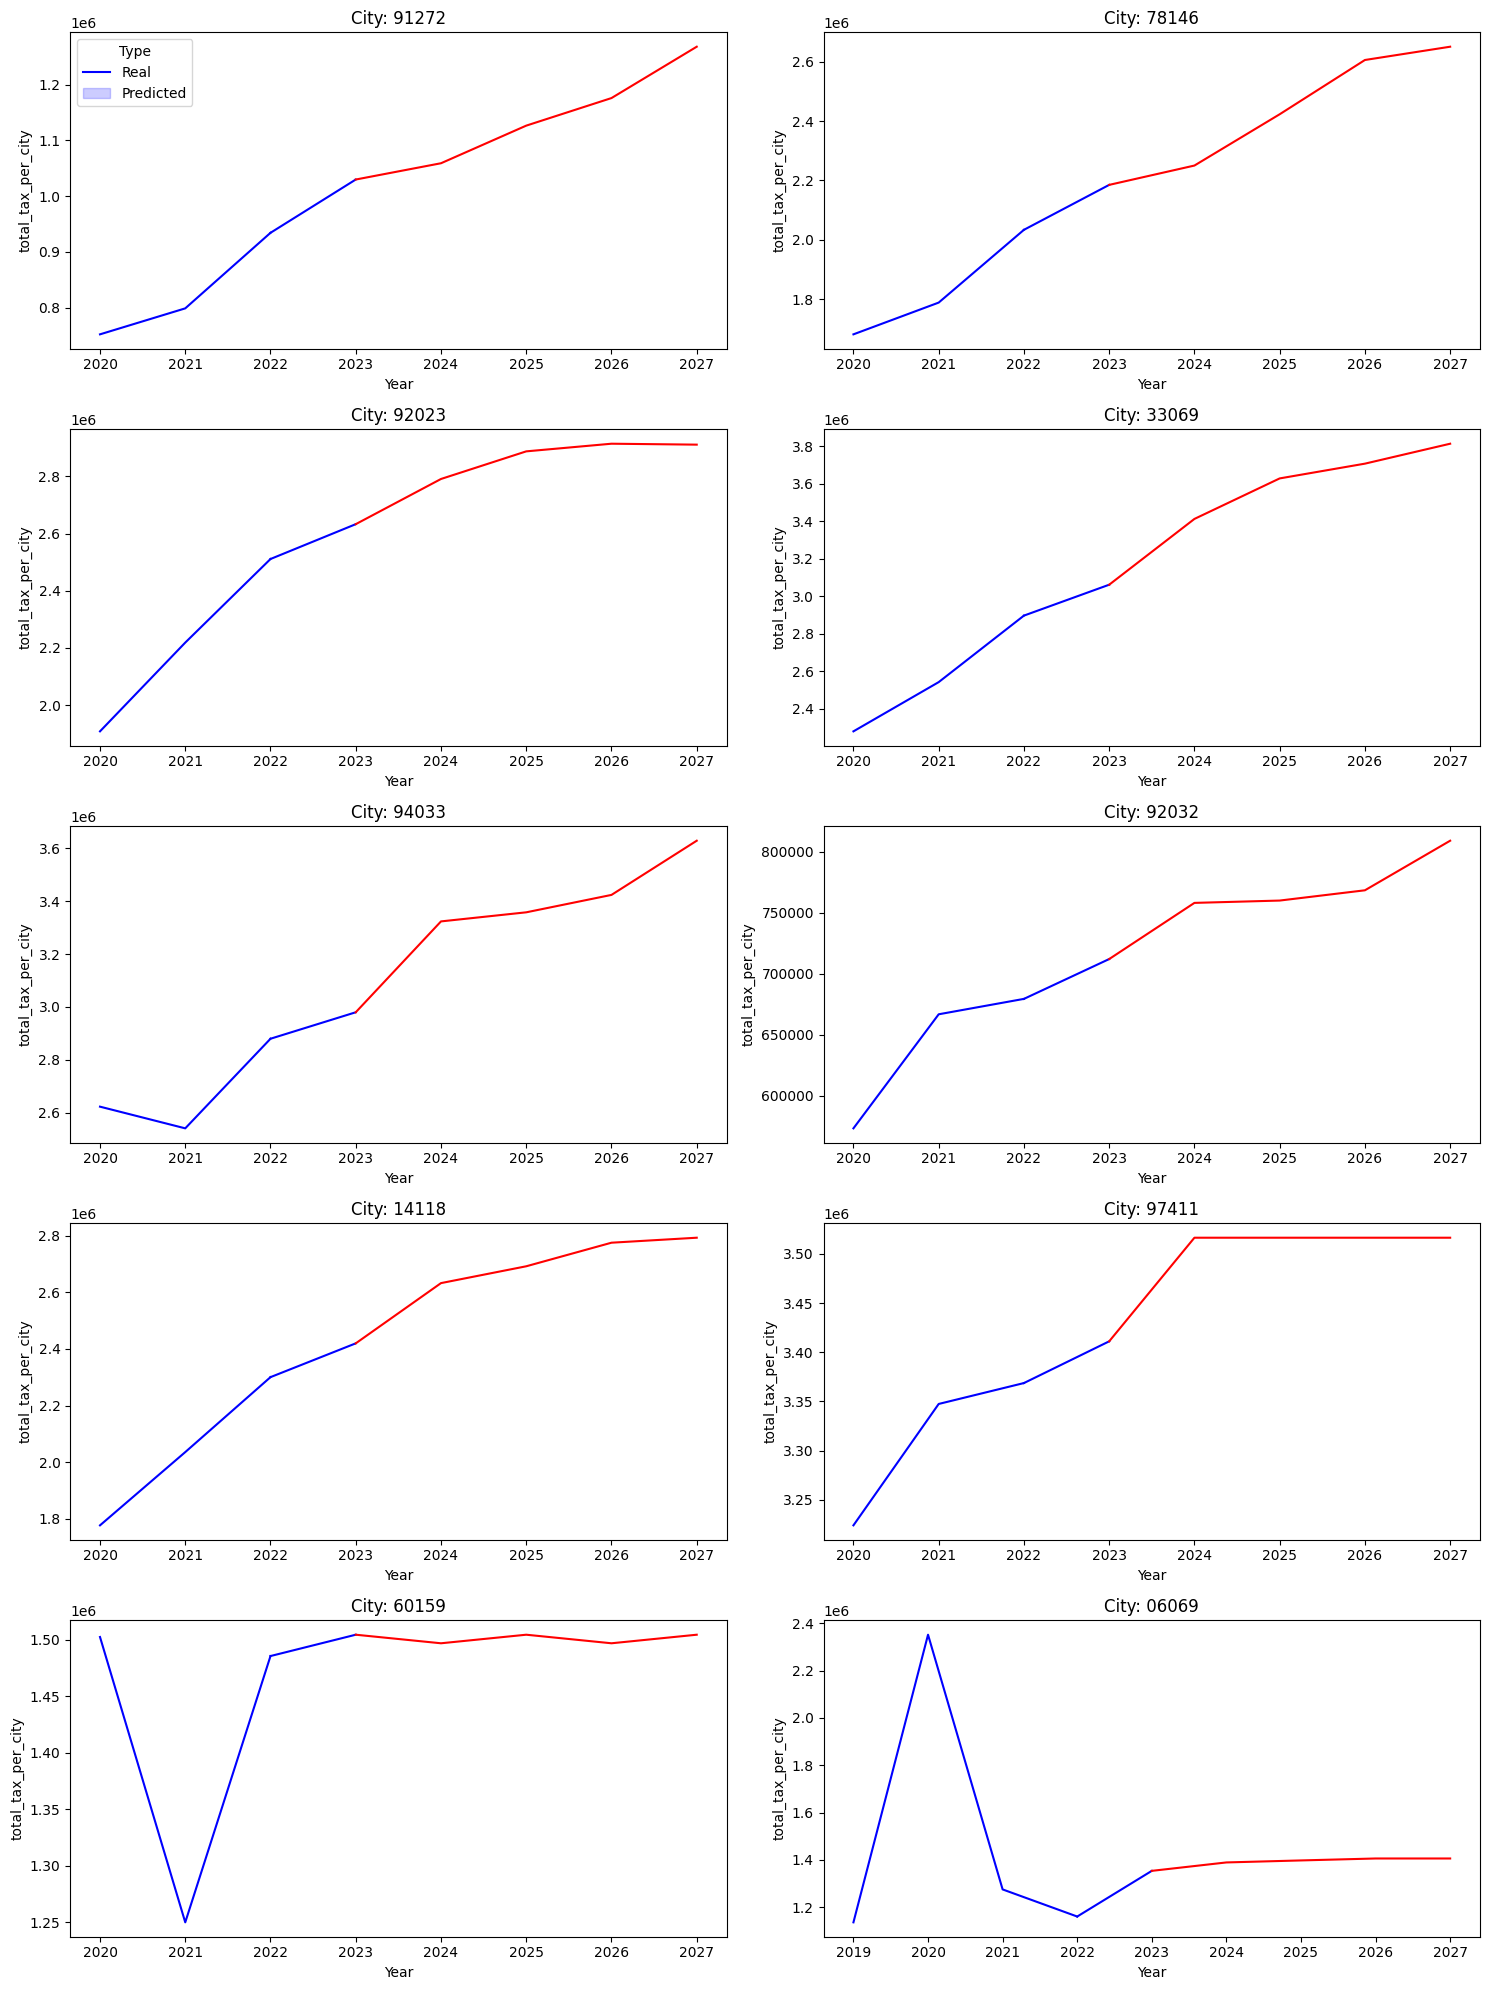

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calcular la tasa de crecimiento relativa para cada ciudad, excluyendo outliers
growth_rates = {}

filtered_df = df_ificom_clean_to_be_predictedV2[~df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

non_outlier_df = filtered_df[~filtered_df['Commune_Code_INSEE'].isin(outlier_communes)]

for city in non_outlier_df['Commune_Code_INSEE'].drop_duplicates():
    city_data = non_outlier_df[non_outlier_df['Commune_Code_INSEE'] == city]
    initial_value = city_data['total_tax_per_city'].iloc[0]
    final_value = city_data['total_tax_per_city'].iloc[-1]

    growth_rate = (final_value - initial_value) / initial_value
    growth_rates[city] = growth_rate

# Convertir el diccionario a un DataFrame para facilitar la selección
growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# 2. Seleccionar 10 ciudades aleatorias
random_10_cities = growth_rates_df['Commune_Code_INSEE'].sample(10).tolist()
selected_data = non_outlier_df[non_outlier_df['Commune_Code_INSEE'].isin(random_10_cities)].sort_values(by='Year')

# 3. Graficar estas 10 ciudades con una línea continua que cambia de color
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for idx, city in enumerate(random_10_cities):
    row = idx // 2
    col = idx % 2
    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city]

    # Obtén el último punto de predicted = False y el primero de predicted = True
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]

    # Dibuja todos los datos de predicted = False
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Conecta el último punto de predicted = False con el primero de predicted = True
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b')

    # Dibuja todos los datos de predicted = True
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Type', labels=['Real', 'Predicted'])

plt.tight_layout()
plt.show()


#Show the outliers  (do we need to develop a unique method for thenm)

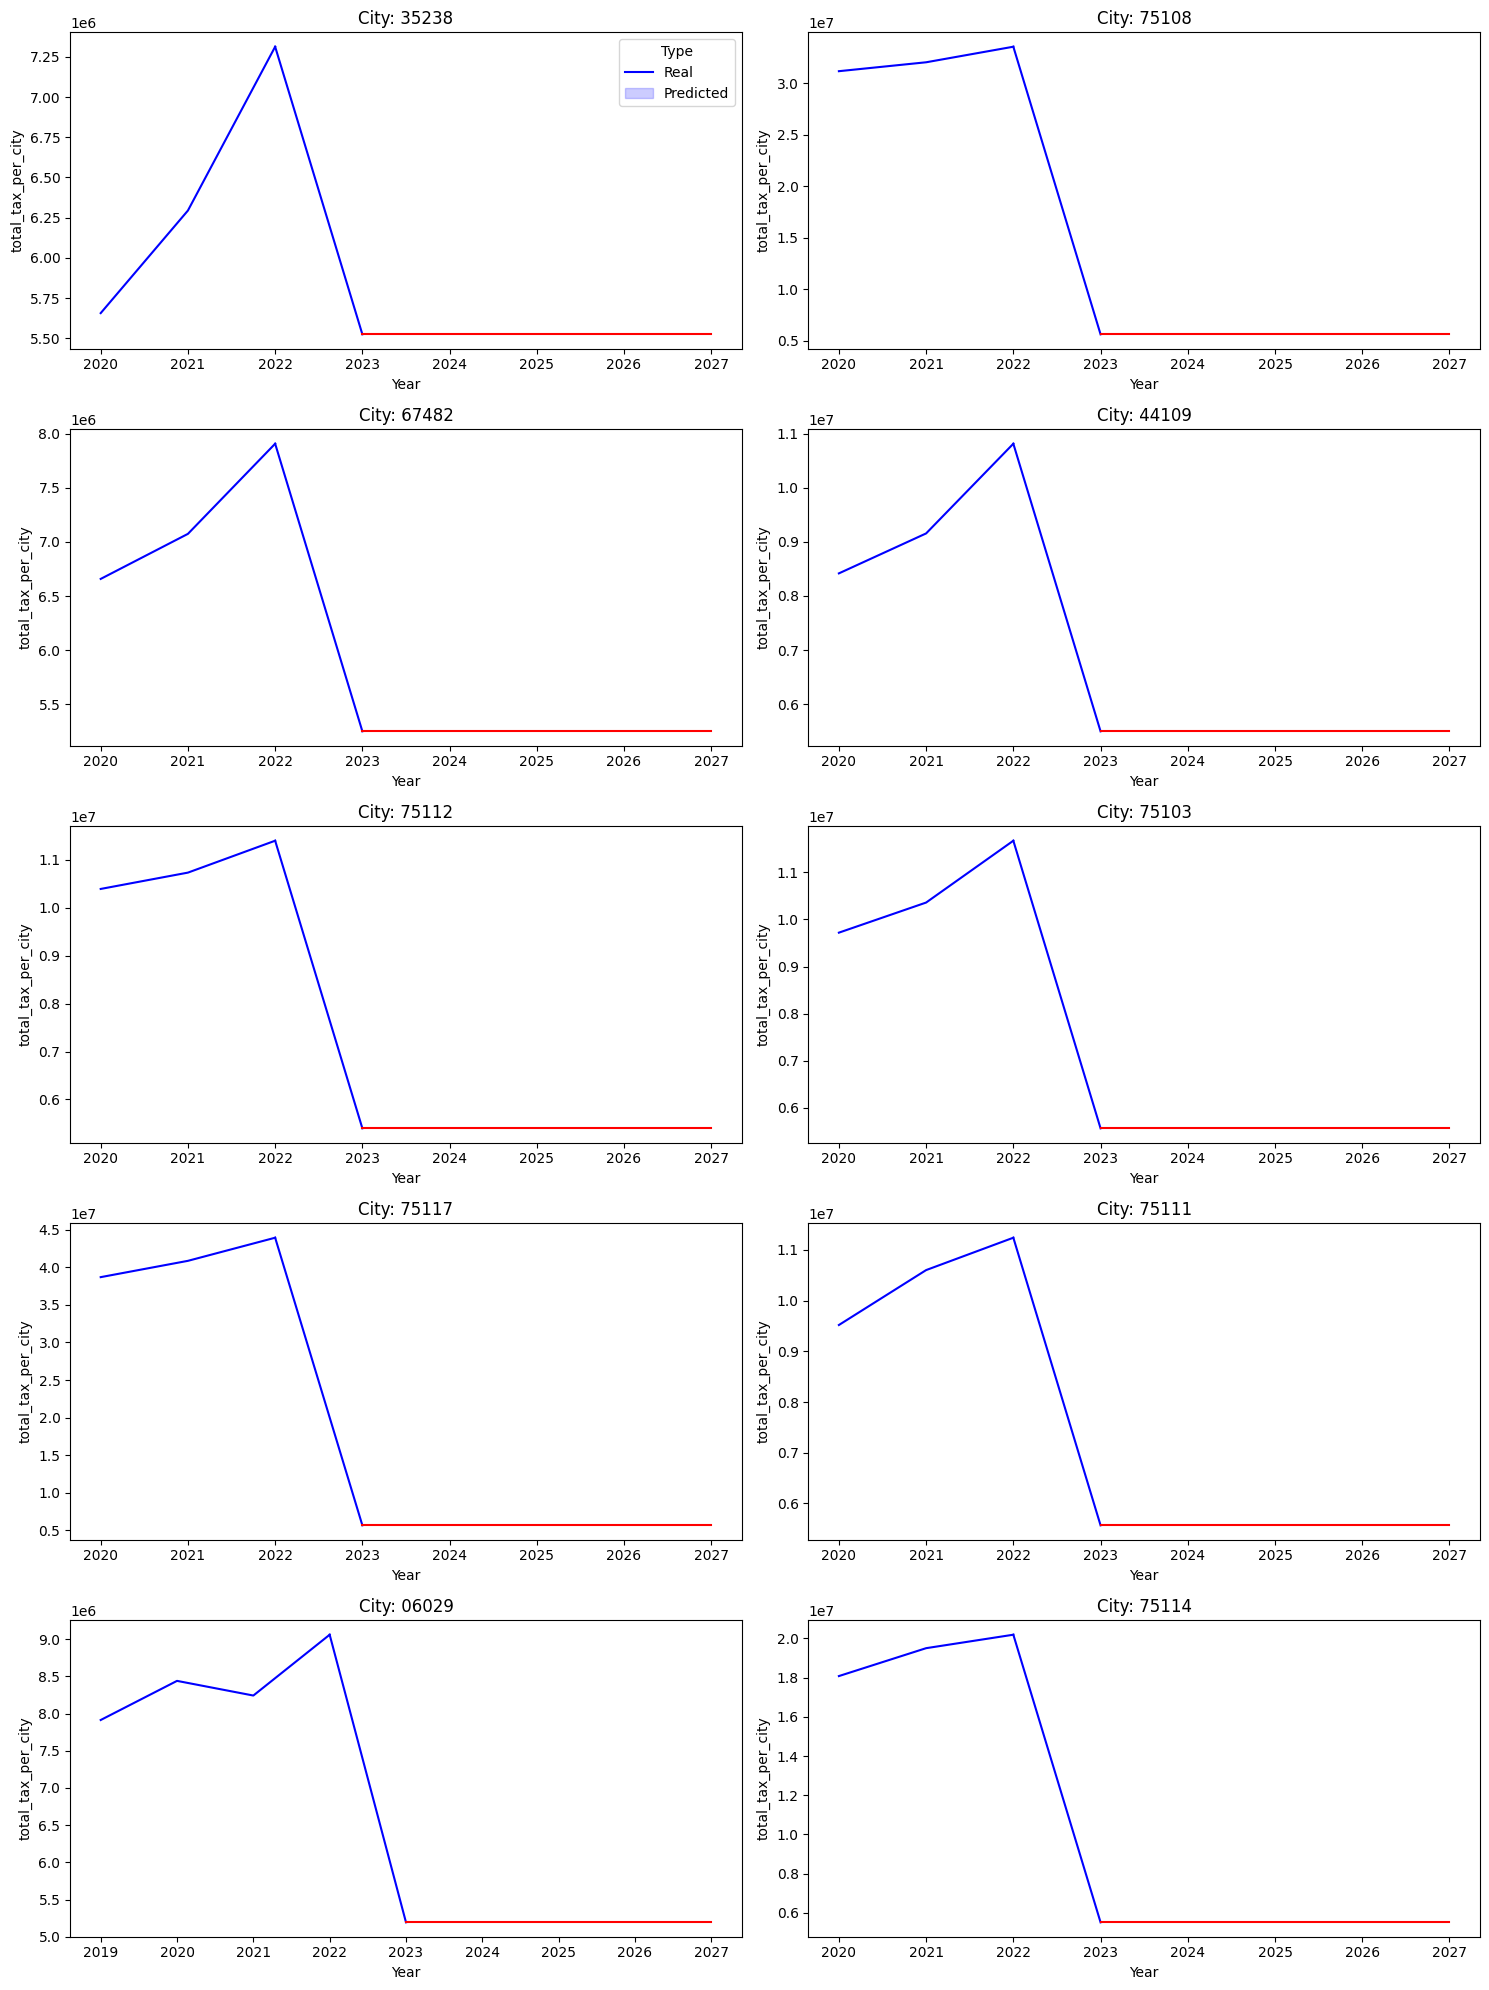

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract outlier cities
outlier_df = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# 2. Calculate the growth rate for each outlier city
growth_rates = {}
for city in outlier_df['Commune_Code_INSEE'].drop_duplicates():
    city_data = outlier_df[outlier_df['Commune_Code_INSEE'] == city]
    initial_value = city_data['total_tax_per_city'].iloc[0]
    final_value = city_data['total_tax_per_city'].iloc[-1]

    growth_rate = (final_value - initial_value) / initial_value
    growth_rates[city] = growth_rate

# Convert growth rates to DataFrame
growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# 3. Select 10 random outlier cities
random_10_cities = growth_rates_df['Commune_Code_INSEE'].sample(10).tolist()
selected_data = outlier_df[outlier_df['Commune_Code_INSEE'].isin(random_10_cities)].sort_values(by='Year')

# 4. Plot data for these cities
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
for idx, city in enumerate(random_10_cities):
    row = idx // 2
    col = idx % 2
    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city]

    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]

    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b')

    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Type', labels=['Real', 'Predicted'])

plt.tight_layout()
plt.show()


In [37]:
#As we see the model is not working for outliers cities, because it wasnt train with those values ( por que si se entrenaba con esos valroes esto dana los resultados de los no outliers)

In [39]:
df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]


#Predice con prophet la variable total_tax_per_city para las lineas en donde predicted= True. Basadote en las lineas donde predicted=False. Los Timeseries son para cada Commune_Code_INSEE,
# por cada Year. Puedes agregar como variables externas: latitude, longitude, mean,median,min,max,mean_distance_to_10_nearest.
# Los valores predecidos ponlos en la columna total_tax_per_city y crea una nueva columna llamada Prophet ==True.

#Los datos estan en df_ificom_clean_to_be_predictedV2, pero solo utiliza las ciudades que son outliers df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]
#Aqui un ejemplo:



,index,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,to_be_predicted,predicted
27,12.0,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06029,CANNES,626.0,2770439.0,12642.0,ificom-2019.xls,2019.0,43.552620,7.004276,7913892.0,NaN,NaN,NaN,NaN,NaN,11.761781,False,False
28,13.0,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06029,CANNES,658.0,2901833.0,12827.0,ificom-2020.xlsx,2020.0,43.552620,7.004276,8440166.0,7913892.0,7.913892e+06,7913892.00,7913892.0,7913892.0,11.761781,False,False
29,14.0,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06029,CANNES,664.0,2827815.0,12414.0,ificom-2021.xlsx,2021.0,43.552620,7.004276,8242896.0,8440166.0,8.177029e+06,8177029.00,7913892.0,8440166.0,11.761781,False,False
30,15.0,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06029,CANNES,707.0,3044836.0,12816.0,ificom-2022.xlsx,2022.0,43.552620,7.004276,9060912.0,8242896.0,8.198985e+06,8242896.00,7913892.0,8440166.0,11.761781,False,False
31,611.0,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06029,CANNES,NaN,NaN,NaN,NaN,2023.0,43.552620,7.004276,5192926.0,9060912.0,8.414466e+06,8341531.00,7913892.0,9060912.0,11.761781,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,805.0,ILE-DE-FRANCE,VAL-DE-MARNE,94068,SAINT MAUR DES FOSSES,NaN,NaN,NaN,NaN,2023.0,48.799068,2.493865,5238443.5,7457520.0,6.745476e+06,6768912.00,6009996.0,7457520.0,5.006658,False,True
1566,NaN,ILE-DE-FRANCE,VAL-DE-MARNE,94068,SAINT MAUR DES FOSSES,NaN,NaN,NaN,NaN,2024.0,48.799068,2.493865,5238443.5,5238443.5,6.368718e+06,6389454.00,5238443.5,7457520.0,5.006658,False,True
1567,NaN,ILE-DE-FRANCE,VAL-DE-MARNE,94068,SAINT MAUR DES FOSSES,NaN,NaN,NaN,NaN,2025.0,48.799068,2.493865,5238443.5,5238443.5,6.142663e+06,6009996.00,5238443.5,7457520.0,5.006658,False,True
1568,NaN,ILE-DE-FRANCE,VAL-DE-MARNE,94068,SAINT MAUR DES FOSSES,NaN,NaN,NaN,NaN,2026.0,48.799068,2.493865,5238443.5,5238443.5,5.991960e+06,5624219.75,5238443.5,7457520.0,5.006658,False,True


In [1]:
!pip install pystan==2.19.1.1
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 56.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61973723 sha256=62f45f1321ad6037989ad5c5f2f4f0754de25799bfa4926065f1f94d6cd48744
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 516.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originate

In [1]:
import pandas as pd
from fbprophet import Prophet

# Sample data
# df_ificom_clean_to_be_predictedV2 = ...

# Assuming outlier_communes is already provided
# outlier_communes = ...

# Step 1: Filter the dataframe
df = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# Step 2: Split the data into known and unknown datasets
known_data = df[df['predicted'] == False]
unknown_data = df[df['predicted'] == True]

predicted_values = []

# Step 3: Forecasting for each unique Commune_Code_INSEE
for commune in known_data['Commune_Code_INSEE'].unique():

    # Prepare the dataset for this commune
    commune_data = known_data[known_data['Commune_Code_INSEE'] == commune]
    commune_forecast = unknown_data[unknown_data['Commune_Code_INSEE'] == commune]

    # Prepare data for Prophet
    ts_data = pd.DataFrame({
        'ds': pd.to_datetime(commune_data['Year'], format='%Y'),
        'y': commune_data['total_tax_per_city']
    })

    # External regressors
    for col in ['latitude', 'longitude', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']:
        ts_data[col] = commune_data[col]

    # Initialize and train the Prophet model
    model = Prophet(yearly_seasonality=True)
    for col in ['latitude', 'longitude', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']:
        model.add_regressor(col)

    model.fit(ts_data)

    # Prepare dataframe for prediction
    future = model.make_future_dataframe(periods=len(commune_forecast), freq='Y')
    for col in ['latitude', 'longitude', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']:
        future[col] = list(commune_data[col]) + list(commune_forecast[col])

    # Predict
    forecast = model.predict(future)

    # Append the predicted values for the unknown data
    predicted_values.extend(forecast['yhat'][-len(commune_forecast):].tolist())

# Step 4: Add the predicted values to the unknown data
unknown_data['total_tax_per_city'] = predicted_values
unknown_data['Prophet'] = True

# The dataframe with the predicted values
# unknown_data


ModuleNotFoundError: ignored

209

In [ ]:
df_ificom_clean_to_be_predictedV2

,level_0,index,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,to_be_predicted,predicted
0,0,0.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2235849.0,9388.0,ificom-2019.xls,2019.0,44.579860,6.064861,535116.000,NaN,NaN,NaN,NaN,NaN,110.365115,False,False
1,1,1.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.579860,6.064861,483816.000,535116.000,5.351160e+05,535116.0,535116.0,535116.000,110.365115,False,False
2,2,2.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,65.0,2268207.0,8156.0,ificom-2021.xlsx,2021.0,44.579860,6.064861,530140.000,483816.000,5.094660e+05,509466.0,483816.0,535116.000,110.365115,False,False
3,3,3.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,71.0,2264449.0,8403.0,ificom-2022.xlsx,2022.0,44.579860,6.064861,596613.000,530140.000,5.163573e+05,530140.0,483816.0,535116.000,110.365115,False,False
4,4,608.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,NaN,NaN,NaN,NaN,2023.0,44.579860,6.064861,648733.875,596613.000,5.364212e+05,532628.0,483816.0,596613.000,110.365115,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,813,605.0,LA REUNION,LA REUNION,97422,TAMPON,93.0,2143365.0,8852.0,ificom-2020.xlsx,2020.0,-21.223275,55.558488,823236.000,NaN,NaN,NaN,NaN,NaN,6080.664846,False,False
1022,814,606.0,LA REUNION,LA REUNION,97422,TAMPON,100.0,2115447.0,8301.0,ificom-2021.xlsx,2021.0,-21.223275,55.558488,830100.000,823236.000,8.232360e+05,823236.0,823236.0,823236.000,6080.664846,False,False
1023,815,607.0,LA REUNION,LA REUNION,97422,TAMPON,95.0,2450843.0,11759.0,ificom-2022.xlsx,2022.0,-21.223275,55.558488,1117105.000,830100.000,8.266680e+05,826668.0,823236.0,830100.000,6080.664846,False,False
1024,816,816.0,LA REUNION,LA REUNION,97422,TAMPON,NaN,NaN,NaN,NaN,2023.0,-21.223275,55.558488,1269396.125,1117105.000,9.234803e+05,830100.0,823236.0,1117105.000,6080.664846,False,False


In [ ]:
df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE']=='05061']

,level_0,index,Region,Department,Commune_Code_INSEE,City,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,to_be_predicted,predicted
0,0,0.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2235849.0,9388.0,ificom-2019.xls,2019.0,44.57986,6.064861,535116.000,NaN,NaN,NaN,NaN,NaN,110.365115,False,False
1,1,1.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.57986,6.064861,483816.000,535116.000,535116.000000,535116.0,535116.0,535116.000,110.365115,False,False
2,2,2.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,65.0,2268207.0,8156.0,ificom-2021.xlsx,2021.0,44.57986,6.064861,530140.000,483816.000,509466.000000,509466.0,483816.0,535116.000,110.365115,False,False
3,3,3.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,71.0,2264449.0,8403.0,ificom-2022.xlsx,2022.0,44.57986,6.064861,596613.000,530140.000,516357.333333,530140.0,483816.0,535116.000,110.365115,False,False
4,4,608.0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,NaN,NaN,NaN,NaN,2023.0,44.57986,6.064861,648733.875,596613.000,536421.250000,532628.0,483816.0,596613.000,110.365115,False,True
5,817,NaN,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,NaN,NaN,NaN,NaN,2024.0,44.57986,6.064861,NaN,648733.875,558883.775000,535116.0,483816.0,648733.875,110.365115,True,NaN
